In [1]:
!pip3 -qq install torch==0.4.1
!pip install -qq bokeh==0.13.0
!pip install -qq eli5==0.8
!wget -O surnames.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1z7avv1JiI30V4cmHJGFIfDEs9iE4SHs5"

    100% |████████████████████████████████| 519.5MB 34kB/s 
fastai 1.0.49 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.49 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
    100% |████████████████████████████████| 16.0MB 1.2MB/s 
    100% |████████████████████████████████| 102kB 3.9MB/s 


In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor
    
np.random.seed(42)

# Свёрточные нейронные сети

## Классификация фамилий

Будем учиться предсказывать, является ли слово фамилией.

In [0]:
from sklearn.model_selection import train_test_split

with open('surnames.txt') as f:
    lines = f.readlines()
    data = [line.strip().split('\t')[0] for line in lines]
    labels = np.array([int(line.strip().split('\t')[1]) for line in lines])
    del lines
    
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.33, random_state=42)

Посмотрим на данные:

In [8]:
list(zip(train_data, train_labels))[::1500]

[('вожакам', 0),
 ('посвящения', 0),
 ('изменницы', 0),
 ('тензорам', 0),
 ('Родзевич', 1),
 ('поломку', 0),
 ('ПРОВЕРКАМ', 0),
 ('майка', 0),
 ('ошеломлении', 0),
 ('эркере', 0),
 ('дешифрировании', 0),
 ('затоваривание', 0),
 ('громыханий', 0),
 ('выволочка', 0),
 ('Волдыри', 0),
 ('сербки', 0),
 ('ОТЛИЧИИ', 0),
 ('РАДИОГРАММА', 0),
 ('поэтике', 0),
 ('гобоя', 0),
 ('ОБЛАСТЯМИ', 0),
 ('пациентах', 0),
 ('трясогузка', 0),
 ('утепления', 0),
 ('Фингалу', 0),
 ('Хищение', 0),
 ('Джамал', 0),
 ('Лавчонка', 0),
 ('скольжению', 0),
 ('восстание', 0),
 ('Гудмэн', 1),
 ('консортах', 0),
 ('инфузорий', 0),
 ('постоянстве', 0),
 ('вахтенными', 0),
 ('полновластия', 0)]

Данные ещё и сильно несбалансированы - положительных примеров в несколько раз меньше:

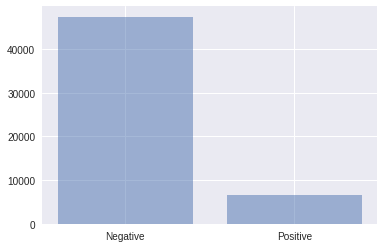

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

positive_count = np.sum(train_labels == 1)
negative_count = len(train_labels) - positive_count
 
plt.bar(np.arange(2), [negative_count, positive_count], align='center', alpha=0.5)
plt.xticks(np.arange(2), ('Negative', 'Positive'))
    
plt.show()

Accuracy очень легко оптимизировать - просто предсказывайте всегда ноль:

In [6]:
print('Accuracy = {:.2%}'.format((train_labels == 0).mean()))

Accuracy = 87.90%


Однако это будет довольно бесполезно - всегда говорить, что слово не является фамилией. Это, конечно, вопрос - что хуже, зря объявить слово фамилией (ошибка первого рода) или не найти фамилию.

![](https://effectsizefaq.files.wordpress.com/2010/05/type-i-and-type-ii-errors.jpg =x350)  
*From [effectsizefaq.com](https://effectsizefaq.com/2010/05/31/i-always-get-confused-about-type-i-and-ii-errors-can-you-show-me-something-to-help-me-remember-the-difference/)*

Будем замерять precision, recall и их комбинацию - $F_1$-меру.

![precision-recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png =x600)  
*From [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)*

$$\text{precision} = \frac{tp}{tp + fp}.$$
$$\text{recall} = \frac{tp}{tp + fn}.$$
$$\text{F}_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}.$$

Начнём с бейзлайна на регулярках.

In [7]:
positives = [train_data[i] for i in range(len(train_labels)) if train_labels[i]]
positives[:5]

['ШАФНЕР', 'крест', 'Берса', 'Гаспорян', 'БЕЛЬЯНИНЫ']

In [9]:
#@title Супер-бейзлайн
surname_indicators = "^[А-Я][а-я], .*ский,  .*ов, .*ова,  *ина, .*ый,  .*ой" #@param {type:"raw"}

surname_indicators = surname_indicators.split(', ')

import re

regexs = [re.compile(regex) for regex in surname_indicators]

preds = np.array([any(regex.match(word) for regex in regexs) for word in test_data])

from sklearn.metrics import f1_score
print('F1-score = {:.2%}'.format(f1_score(test_labels, preds)))

F1-score = 39.26%


А теперь серьёзно - бейзлайн на логистической регрессии поверх N-грамм символов.

**Задание** Сделать классификацию с LogisticRegression моделью. Посчитать F1-меру.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 3), lowercase=False)
vectorizer.fit(train_data)
X_train, X_test = vectorizer.transform(train_data), vectorizer.transform(test_data)

model = LogisticRegression().fit(X_train, train_labels)

test_preds = model.predict(X_test)
print('F1-score = {:.2%}'.format(f1_score(test_labels, test_preds)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1-score = 66.24%


Посмотрим на предсказания

In [11]:
import eli5

eli5.show_weights(model, vec=vectorizer, top=40)

Weight?,Feature
+2.855,кий
+2.830,юк
+2.646,кин
+2.624,чук
+2.363,ев
+2.156,вой
+2.123,сон
+2.054,овы
+2.021,цк
+2.020,енк


In [12]:
sample_ind = np.random.randint(len(test_data))
eli5.show_prediction(model, test_data[sample_ind], vec=vectorizer, targets=['surname'], target_names=['word', 'surname'])

Кроме тупого подсчета F1-score можно посмотреть на precision-recall кривые. Во-первых, они красивые. Во-вторых, по ним видно, что можно повысить качество (F1-score), подобрав другой порог - **хотя на тесте это делать нельзя**.

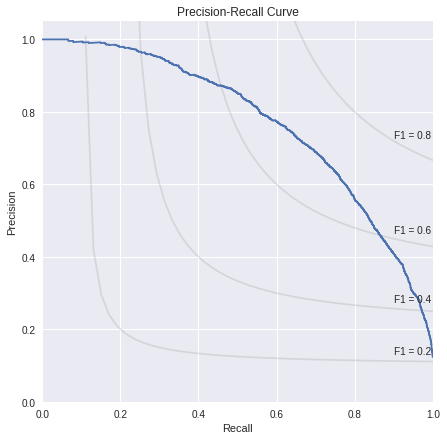

In [13]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(test_labels, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(7, 7))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('F1 = {0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

plt.plot(recall, precision)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.show()

**Задание** Придумайте признаки, чтобы улучшить качество модели.

## Character-Level Convolutions

### Общее описание сверток

Напомню, свертки - это то, с чего начался хайп нейронных сетей в районе 2012-ого.

Работают они примерно так:  
![Conv example](https://image.ibb.co/e6t8ZK/Convolution.gif)   
From [Feature extraction using convolution](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution).

Формально - учатся наборы фильтров, каждый из которых скалярно умножается на элементы матрицы признаков. На картинке выше исходная матрица сворачивается с фильтром
$$
 \begin{pmatrix}
  1 & 0 & 1 \\
  0 & 1 & 0 \\
  1 & 0 & 1
 \end{pmatrix}
$$

Но нужно не забывать, что свертки обычно имеют ещё такую размерность, как число каналов. Например, картинки имеют обычно три канала: RGB.  
Наглядно демонстрируется как выглядят при этом фильтры [здесь](http://cs231n.github.io/convolutional-networks/#conv).

После сверток обычно следуют pooling-слои. Они помогают уменьшить размерность тензора, с которым приходится работать. Самым частым является max-pooling:  
![maxpooling](http://cs231n.github.io/assets/cnn/maxpool.jpeg =x300)  
From [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/#pool)

### Свёртки для текстов

Для текстов свертки работают как n-граммные детекторы (примерно). Каноничный пример символьной сверточной сети:

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png =x500)  
From [Character-Aware Neural Language Models](https://arxiv.org/abs/1508.06615)

*Сколько учится фильтров на данном примере?*

На картинке показано, как из слова извлекаются 2, 3 и 4-граммы. Например, желтые - это триграммы. Желтый фильтр прикладывают ко всем триграммам в слове, а потом с помощью global max-pooling извлекают наиболее сильный сигнал.

Что это значит, если конкретнее?

Каждый символ отображается с помощью эмбеддингов в некоторый вектор. А их последовательности - в конкатенации эмбеддингов.  
Например, "abs" $\to [v_a; v_b; v_s] \in \mathbb{R}^{3 d}$, где $d$ - размерность эмбеддинга. Желтый фильтр $f_k$ имеет такую же размерность $3d$.  
Его прикладывание - это скалярное произведение $\left([v_a; v_b; v_s] \odot f_k \right) \in \mathbb R$ (один из желтых квадратиков в feature map для данного фильтра).

Max-pooling выбирает $max_i \left( [v_{i-1}; v_{i}; v_{i+1}] \odot f_k \right)$, где $i$ пробегается по всем индексам слова от 1 до $|w| - 1$ (либо по большему диапазону, если есть padding'и).   
Этот максимум соответствует той триграмме, которая наиболее близка к фильтру по косинусному расстоянию.

В результате в векторе после max-pooling'а закодирована информация о том, какие из n-грамм встретились в слове: если встретилась близкая к нашему $f_k$ триграмма, то в $k$-той позиции вектора будет стоять большое значение, иначе - маленькое.

А учим мы как раз фильтры. То есть сеть должна научиться определять, какие из n-грамм значимы, а какие - нет.

### Игрушечный пример

Посмотрим на примере, что там происходит. Возьмем слово:

In [0]:
word = 'Смирнов'

Для начала нужно перенумеровать символы:

In [15]:
char2index = {symb: ind for ind, symb in enumerate(set(word))}

char2index

{'С': 2, 'в': 5, 'и': 6, 'м': 3, 'н': 1, 'о': 0, 'р': 4}

Каждому символу сопоставляется эмбеддинг. Простейший способ сделать эмбеддинги - взять единичную матрицу. Когда у нас были десятки тысяч слов, такие эмбеддинги были не оч, а сейчас всего несколько символов вполне адекватно присвоить им ортогональные вектора небольшой размерности.

In [16]:
embeddings = torch.eye(len(char2index))

embeddings

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.]])

Построим тензор индексов символов слова:

In [17]:
word_tensor = torch.LongTensor([char2index[symb] for symb in word])

word_tensor

tensor([2, 3, 6, 4, 1, 0, 5])

Отобразим его в эмбеддинги. Получили такой же прямоугольничек, как на картинке (транспонирование нужно, чтобы смотрело в ту же сторону).

In [18]:
word_embs = embeddings[word_tensor].t()

word_embs

tensor([[0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0.]])

Теперь дело дошло до сверток. Сделаем фильтр-детектор триграммы `нов`:

In [19]:
kernel_name = 'нов'

kernel_indices = torch.LongTensor([char2index[symb] for symb in kernel_name])
kernel_weights = embeddings[kernel_indices].t()

kernel_weights

tensor([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 0.]])

Чтобы посчитать свёртку, воспользуемся функцией:

```python
F.conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) -> Tensor
```

input: input tensor of shape ($N \times C_{in} \times H_{in} \times W_{in}$)  
weight: filters of shape ($C_{out} \times C_{in} \times H_{out} \times W_{out}$)

$N$ - размер батча (1 у нас). $C_{in}$ - число каналов. В нашем случае оно всегда будет 1 (пока что). $C_{out}$ - число фильтров. Оно пока 1.

Нам понадобятся четырехмерные тензоры, для этого воспользуемся `view`:

In [20]:
word_embs = word_embs.view(1, 1, word_embs.shape[0], word_embs.shape[1])
kernel_weights = kernel_weights.view(1, 1, kernel_weights.shape[0], kernel_weights.shape[1])

conv_result = F.conv2d(word_embs, kernel_weights)[0, 0]

print('Conv =', conv_result)
print('Max pooling =', conv_result.max())

Conv = tensor([[0., 0., 0., 0., 3.]])
Max pooling = tensor(3.)


Свертка сказала, что данный фильтр есть на последней позиции. Пулинг сказал, пофиг на какой позиции - главное, он есть.

### Подготовка данных

Первый шаг - определить, какой длины слова у нас. Ограничимся каким-то числом, а более длинные будем обрезать.

In [21]:
from collections import Counter 
    
def find_max_len(counter, threshold):
    sum_count = sum(counter.values())
    cum_count = 0
    for i in range(max(counter)):
        cum_count += counter[i]
        if cum_count > sum_count * threshold:
            return i
    return max(counter)

word_len_counter = Counter()
for word in train_data:
    word_len_counter[len(word)] += 1
    
threshold = 0.99
MAX_WORD_LEN = find_max_len(word_len_counter, threshold)

print('Max word length for {:.0%} of words is {}'.format(threshold, MAX_WORD_LEN))

Max word length for 99% of words is 17


Соберем отображение из символов в индексы.

In [22]:
chars = set()
for word in train_data:
    chars.update(word)

char_index = {c : i + 1 for i, c in enumerate(chars)}
char_index['<pad>'] = 0
    
print(char_index)

{'З': 1, 'а': 2, 'л': 3, 'С': 4, 'Ш': 5, 'п': 6, 'я': 7, 'ё': 8, 'Д': 9, 'Р': 10, 'Ь': 11, '2': 12, 'ь': 13, 'в': 14, 'Л': 15, '-': 16, 'Щ': 17, 'Н': 18, 'А': 19, 'М': 20, 'э': 21, 'ш': 22, 'ц': 23, 'Ц': 24, 'о': 25, 'щ': 26, '.': 27, '3': 28, "'": 29, ' ': 30, 'х': 31, 'Х': 32, '/': 33, 'Ч': 34, 'Ё': 35, 'й': 36, '’': 37, 'Ъ': 38, '»': 39, 'Г': 40, 'к': 41, 'Б': 42, 'К': 43, 'ф': 44, 'Т': 45, '·': 46, 'ó': 47, 'ъ': 48, 'ы': 49, '”': 50, '7': 51, 'О': 52, 'Я': 53, 'у': 54, '4': 55, 'Ó': 56, 'з': 57, 'д': 58, 'р': 59, 'ч': 60, '“': 61, 'ж': 62, 'И': 63, 'Ж': 64, 'В': 65, 'б': 66, 'Э': 67, 'ѐ': 68, 'У': 69, 'т': 70, 'Ф': 71, 'н': 72, 'г': 73, 'м': 74, 'Ы': 75, 'Ю': 76, '«': 77, 'е': 78, 'П': 79, 'Е': 80, 'с': 81, 'и': 82, 'ю': 83, 'Й': 84, '<pad>': 0}


**Задание** Сконвертируйте данные

In [0]:
def convert_data(data, max_word_len, char_index):
    res = np.zeros((len(data), max_word_len))
    for i, word in enumerate(data):
        word = word[-max_word_len:]
        res[i][:len(word)] = [char_index.get(symb, 0) for symb in word]
  
    return res

X_train = convert_data(train_data, MAX_WORD_LEN, char_index)
X_test = convert_data(test_data, MAX_WORD_LEN, char_index)

In [0]:
def iterate_batches(X, y, batch_size):
    num_samples = X.shape[0]

    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        
        batch_idx = indices[start: end]
        
        yield X[batch_idx], y[batch_idx]

### MyFirstConvCharNN

Теперь построим свёрточную модель.

Пусть она будет строить триграммы - то есть применять фильтры на 3 символа.

Начнем с последовательности: `nn.Embedding -> nn.Conv2d -> nn.ReLU -> max pooling -> nn.Linear`

`nn.Conv2d` - это слой, содержащий создание и инициализацию фильтров, и вызов `F.conv2d` к ним и входу.

*Лайфхак:* последовательности операций можно запаковывать в `nn.Sequential`.

In [0]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, filters_count):
        super().__init__()
        
        self._embedding = nn.Embedding(vocab_size, emb_dim)
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(4, emb_dim)), # 4 - conv size
            nn.ReLU(inplace=True)
        )
        self._out_layer = nn.Linear(filters_count, 1)
        
    def forward(self, inputs):
        '''
        inputs - LongTensor with shape (batch_size, max_word_len)
        outputs - FloatTensor with shape (batch_size,)
        '''
        
        outputs = self.embed(inputs)
        return self._out_layer(outputs).squeeze(-1)
    
    def embed(self, inputs):
        outputs = self._embedding(inputs)  # shape: (batch_size, max_word_len, emb_dim)
        outputs = outputs.unsqueeze(1) # (batch_size, 1, max_word_len, emb_dim) 
        outputs = self._conv3(outputs) # (batch_size, filters_count, H_out=(max_word_len - filter_size + 1), W_out=1)
#         outputs = self._maxpool(outputs) # (batch_size, filters_count, H_out / kernel_size[0], 1)
        outputs = outputs.max(dim=2)[0]
        outputs = outputs.squeeze(-1) # (batch_size, filters_count)
        return outputs
        

Проверьте, что всё работает:

In [0]:
X_batch, y_batch = next(iterate_batches(X_train, train_labels, 32))
X_batch, y_batch = torch.cuda.LongTensor(X_batch), torch.cuda.LongTensor(y_batch)

model = ConvClassifier(len(char_index) + 1, 24, 64).cuda()
logits = model(X_batch)

**Задание** Подсчитайте precision, recall и F1-score для полученных предсказаний.

In [0]:
def TP(logits, labels):
    logits_bin = logits.ge(0).type(torch.long).cpu()
    return torch.dot(logits_bin, labels.cpu()).data.tolist()

def FP(logits, labels):
    logits_bin = logits.ge(0).type(torch.long).cpu()
    return torch.dot(logits_bin, labels.eq(0).type(torch.long).cpu()).data.tolist()

def FN(logits, labels):
    logits_bin = logits.ge(0).type(torch.long).cpu()
    return torch.dot(logits_bin.eq(0).type(torch.long).cpu(), labels.cpu()).data.tolist()


def get_precision(tp, fp):
    return tp / (tp + fp) if tp + fp != 0 else 0

def get_recall(tp, fn):
    return tp / (tp + fn) if tp + fn != 0 else 0


def get_f1(precision, recall):
    return 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0

In [28]:
'F1 on 1st batch {0:0.2f}'.format(get_f1( get_precision( TP(logits, y_batch), FP(logits, y_batch) ), get_recall( TP(logits, y_batch), FN(logits, y_batch) ) ))

'F1 on 1st batch 0.22'

**Задание** Напишем теперь цикл обучения, который не слишком сложно будет переиспользовать

In [0]:
import math
import time

def do_epoch(model, criterion, data, batch_size, optimizer=None):
    epoch_loss, epoch_tp, epoch_fp, epoch_fn = 0, 0, 0, 0
    
    is_train = not optimizer is None
    model.train(is_train)
    
    data, labels = data
    batchs_count = math.ceil(data.shape[0] / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        for i, (X_batch, y_batch) in enumerate(iterate_batches(data, labels, batch_size)):
            X_batch, y_batch = LongTensor(X_batch), FloatTensor(y_batch)

            logits = model(X_batch)

            loss = criterion(logits, y_batch)
            epoch_loss += loss.item()

            if is_train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            y_batch = y_batch.type(torch.long)
            tp = TP(logits, y_batch)
            fp = FP(logits, y_batch)
            fn = FN(logits, y_batch)

            precision = get_precision(tp, fp)
            recall = get_recall(tp, fn)
            f1 = get_f1(precision, recall)
            
            epoch_tp += tp
            epoch_fp += fp
            epoch_fn += fn

            print('\r[{} / {}]: Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'.format(
                  i, batchs_count, loss.item(), precision, recall, f1), end='')
        
    precision = get_precision(epoch_tp, epoch_fp)
    recall = get_recall(epoch_tp, epoch_fn)
    f1 = get_f1(precision, recall)
        
    return epoch_loss / batchs_count, recall, precision, f1

def fit(model, criterion, optimizer, train_data, epochs_count=1, 
        batch_size=32, val_data=None, val_batch_size=None):
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        start_time = time.time()
        train_loss, train_recall, train_precision, train_f1 = do_epoch(
            model, criterion, train_data, batch_size, optimizer
        )
        
        output_info = '\rEpoch {} / {}, Epoch Time = {:.2f}s: Train Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'
        if not val_data is None:
            val_loss, val_recall, val_precision, val_f1 = do_epoch(model, criterion, val_data, val_batch_size, None)
            
            epoch_time = time.time() - start_time
            output_info += ', Val Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'
            print(output_info.format(epoch+1, epochs_count, epoch_time, 
                                     train_loss, train_recall, train_precision, train_f1,
                                     val_loss, val_recall, val_precision, val_f1))
        else:
            epoch_time = time.time() - start_time
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss))

In [0]:
model = ConvClassifier(len(char_index) + 1, 24, 128).cuda()

criterion = nn.BCEWithLogitsLoss().cuda()

optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad])

fit(model, criterion, optimizer, train_data=(X_train, train_labels), epochs_count=200, 
    batch_size=512, val_data=(X_test, test_labels), val_batch_size=1024)

Epoch 1 / 200, Epoch Time = 2.57s: Train Loss = 0.3401, Precision = 0.31%, Recall = 14.71%, F1 = 0.60%, Val Loss = 0.3037, Precision = 1.98%, Recall = 60.75%, F1 = 3.84%
Epoch 2 / 200, Epoch Time = 2.48s: Train Loss = 0.2756, Precision = 11.78%, Recall = 74.23%, F1 = 20.34%, Val Loss = 0.2596, Precision = 25.09%, Recall = 75.23%, F1 = 37.63%
Epoch 3 / 200, Epoch Time = 2.42s: Train Loss = 0.2417, Precision = 31.26%, Recall = 74.37%, F1 = 44.02%, Val Loss = 0.2379, Precision = 29.48%, Recall = 79.79%, F1 = 43.05%
Epoch 4 / 200, Epoch Time = 2.44s: Train Loss = 0.2224, Precision = 39.58%, Recall = 75.99%, F1 = 52.05%, Val Loss = 0.2232, Precision = 35.61%, Recall = 79.89%, F1 = 49.26%
Epoch 5 / 200, Epoch Time = 2.46s: Train Loss = 0.2100, Precision = 44.36%, Recall = 76.77%, F1 = 56.23%, Val Loss = 0.2124, Precision = 49.39%, Recall = 75.24%, F1 = 59.64%
Epoch 6 / 200, Epoch Time = 2.46s: Train Loss = 0.1994, Precision = 48.88%, Recall = 78.36%, F1 = 60.21%, Val Loss = 0.2068, Precision

**Задание** Проверьте работу классификатора на вашей фамилии.

Нужно не забыть перевести модель в режим инференса - некоторые слои на трейне и инференсе ведут себя по-разному.

In [0]:
model.eval()

surname = "Леонтьева"
surname_tensor = convert_data([surname], MAX_WORD_LEN, char_index)
surname_tensor = torch.cuda.LongTensor(surname_tensor)
# print(surname_tensor.shape)
print('P({} is surname) = {}'.format(surname, torch.sigmoid(model(surname_tensor))))

P(Леонтьева is surname) = tensor([0.9617], device='cuda:0', grad_fn=<SigmoidBackward>)


**Задание** Постройте precision-recall curve для данного классификатора и предыдущей модели

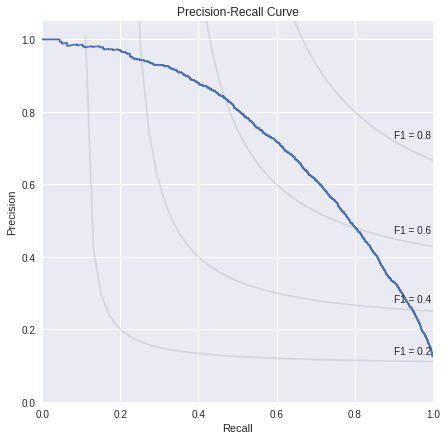

In [0]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

inputs = torch.cuda.LongTensor(X_test)
logits = model(inputs).data.cpu().numpy()
precision, recall, _ = precision_recall_curve(test_labels, logits)

plt.figure(figsize=(7, 7))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('F1 = {0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

plt.plot(recall, precision)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.show()

## Визуализации

### Визуализация эмбеддингов

**Задание** Визуализируем эмбеддинги слов, как это делали раньше

In [0]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=100)
    return scale(tsne.fit_transform(word_vectors))
    
    
def visualize_embeddings(embeddings, token, colors):
    tsne = get_tsne_projection(embeddings)
    draw_vectors(tsne[:, 0], tsne[:, 1], color=colors, token=token)

In [0]:
word_indices = np.random.choice(np.arange(len(test_data)), 1000, replace=False)
words = [test_data[ind] for ind in word_indices]
labels = test_labels[word_indices]
max_word_len = max(len(x) for x in words)
# print(max_word_len)

word_tensor = torch.cuda.LongTensor(convert_data(words, max_word_len, char_index))
print(word_tensor.shape)
embeddings = model.embed(word_tensor)
print(embeddings.shape)
embeddings = embeddings.detach().cpu().numpy()

colors = ['red' if label else 'blue' for label in labels]

visualize_embeddings(embeddings, words, colors)

torch.Size([1000, 20])
torch.Size([1000, 128])
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.004s...
[t-SNE] Computed neighbors for 1000 samples in 0.299s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.396713
[t-SNE] Computed conditional probabilities in 0.080s
[t-SNE] Iteration 50: error = 72.9495239, gradient norm = 0.3248853 (50 iterations in 3.021s)
[t-SNE] Iteration 100: error = 73.8364563, gradient norm = 0.3073391 (50 iterations in 2.490s)
[t-SNE] Iteration 150: error = 73.7557907, gradient norm = 0.3070364 (50 iterations in 3.016s)
[t-SNE] Iteration 200: error = 73.9617386, gradient norm = 0.3125691 (50 iterations in 2.475s)
[t-SNE] Iteration 250: error = 75.0434952, gradient norm = 0.2943079 (50 iterations in 2.578s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.043495
[t-SNE] Iteration 300: error = 1.6672332, gradient norm = 0.0027458 (50 iterations in 2.029s)
[t-SNE] Iteration 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Loading BokehJS ...

### Визуализация полученных свёрток

Кроме всего прочего у нас тут логистическая регрессия сверху. Можно визуализировать ее также, как в eli5.

**Задание** Добиться этого.

In [0]:
model.eval()

word = 'Смирнов'

Посчитайте вероятность, что слово - фамилия.

In [0]:
inputs = torch.cuda.LongTensor(convert_data([word], len(word), char_index))
prob = torch.sigmoid(model(inputs)).item()
prob

0.9401736259460449

Посчитайте результат свертки и пулинга

In [0]:
convs = model._conv3(model._embedding(inputs).unsqueeze(1))
print(convs.shape)
print(convs.squeeze().shape)
maxs, positions = convs.squeeze().max(-1)

torch.Size([1, 128, 4, 1])
torch.Size([128, 4])


Домножьте выход пулинга на веса выходного слоя

In [0]:
linear_weights = maxs * model._out_layer.weight[0]
linear_weights.shape

torch.Size([128])

Посчитайте веса символов: каждый фильтр прикладывается к какой-то позиции - прибавим его вес к накрываемым символам.

In [0]:
symb_weights = np.zeros(len(word))
for i in range(linear_weights.shape[0]):
    symb_weights[positions[i].cpu().numpy()] += linear_weights[i].cpu().detach().numpy()
symb_weights

array([ 5.42058003, -3.31193678, -2.44301582,  3.08033739,  0.        ,
        0.        ,  0.        ])

Визуализируем это:

In [0]:
from IPython.core.display import HTML

def get_color_hex(weight):
    cmap = plt.get_cmap("RdYlGn")
    rgba = cmap(weight, bytes=True)
    return '#%02X%02X%02X' % rgba[:3]

symb_template = '<span style="background-color: {color_hex}">{symb}</span>'
res = '<p>P(surname) = {:.2%}</p>'.format(prob)
for symb, weight in zip(word, symb_weights):
    res += symb_template.format(color_hex=get_color_hex(weight), symb=symb)
res = '<p>' + res + '</p>'

print("Последние 3 буквы в прицнипе не информативны, если что")
HTML(res)

Последние 3 буквы в прицнипе не информативны, если что


Объединим все в функции:

In [0]:
def calc_weights(word):
    inputs = torch.cuda.LongTensor(convert_data([word], len(word), char_index))
    prob = torch.sigmoid(model(inputs)).item()
    convs = model._conv3(model._embedding(inputs).unsqueeze(1))
    maxs, positions = convs.squeeze().max(-1)
    linear_weights = maxs * model._out_layer.weight[0]
    symb_weights = np.zeros(len(word))
    for i in range(linear_weights.shape[0]):
        symb_weights[positions[i].cpu().numpy()] += linear_weights[i].cpu().detach().numpy()
    return prob, symb_weights

def visualize(word):
    prob, symb_weights = calc_weights(word)
    
    symb_template = '<span style="background-color: {color_hex}">{symb}</span>'
    res = '<p>P(surname) = {:.2%}</p>'.format(prob)
    for symb, weight in zip(word, symb_weights):
        res += symb_template.format(color_hex=get_color_hex(weight), symb=symb)
    res = '<p>' + res + '</p>'
    return HTML(res)


visualize('Королев')

## Улучшение модели

**Задание** Для улучшение стабильности модели стоит добавить дропаут `nn.Dropout` - способ занулять часть весов на каждой эпохе для регуляризации модели. Попробуйте добавить его после эмбеддингов и после свертки (а можно еще где-нибудь).

![](https://cdn-images-1.medium.com/max/1044/1*iWQzxhVlvadk6VAJjsgXgg.png =x300)


**Задание** Другой способ регуляризовывать модель - использовать BatchNormalization (`nn.BatchNorm2d`). Попробуйте добавить его после свертки.

**Задание** Еще способ улучшить модель - добавить сверток. Реализуйте модель как на картинке в начале ноутбука: со свертками на 2, 3, 4 символа.

**Задание** Различают Narrow и Wide свёртки - по сути, добавляется ли нулевой паддинг или нет. Для текстов эта разница выглядит так:  
![narrow_vs_wide](https://image.ibb.co/eqGZaS/2018_03_28_11_23_17.png)
*From Neural Network Methods in Natural Language Processing.*

Слева - паддинг отсутствует, справа - есть. Попробуйте добавить паддинг и посмотреть, что получится. Потенциально он поможет выучить хорошие префиксы слова.

In [0]:
class DropoutConvClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, filters_count):
        super().__init__()
        
        self._embedding = nn.Embedding(vocab_size, emb_dim)
        self._dropout = nn.Dropout(0.2)
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(2, emb_dim)),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters_count)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(3, emb_dim)),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters_count),
        )
        self._conv4 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=filters_count, kernel_size=(4, emb_dim)),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(filters_count),
        )
        self._out_layer = nn.Linear(filters_count * 3, 1)
        
    def forward(self, inputs):
        '''
        inputs - LongTensor with shape (batch_size, max_word_len)
        outputs - FloatTensor with shape (batch_size,)
        '''
        
        outputs = self.embed(inputs)
        return self._out_layer(outputs).squeeze(-1)
    
    def embed(self, inputs):
        outputs = self._embedding(inputs)  # shape: (batch_size, max_word_len, emb_dim)
        outputs = self._dropout(outputs)
        outputs = outputs.unsqueeze(1) # (batch_size, 1, max_word_len, emb_dim) 
        convs2 = self._conv2(outputs).max(dim=2)[0]
        convs3 = self._conv3(outputs).max(dim=2)[0]
        convs4 = self._conv4(outputs).max(dim=2)[0]
#         print(convs2.shape, convs3.shape, convs4.shape)
        outputs = torch.cat((convs2, convs3, convs4), dim=1)
#         print(outputs.shape)
        outputs = outputs.squeeze(-1) # (batch_size, filters_count)
        return outputs
        

In [0]:
model = DropoutConvClassifier(len(char_index) + 1, 24, 128).cuda()

criterion = nn.BCEWithLogitsLoss().cuda()

optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad])

fit(model, criterion, optimizer, train_data=(X_train, train_labels), epochs_count=200, 
    batch_size=512, val_data=(X_test, test_labels), val_batch_size=1024)

Epoch 1 / 200, Epoch Time = 4.57s: Train Loss = 0.3472, Precision = 3.88%, Recall = 22.77%, F1 = 6.63%, Val Loss = 0.3018, Precision = 11.74%, Recall = 62.00%, F1 = 19.74%
Epoch 2 / 200, Epoch Time = 4.40s: Train Loss = 0.2835, Precision = 12.04%, Recall = 67.76%, F1 = 20.45%, Val Loss = 0.2695, Precision = 32.20%, Recall = 68.44%, F1 = 43.79%
Epoch 3 / 200, Epoch Time = 4.40s: Train Loss = 0.2600, Precision = 23.54%, Recall = 70.10%, F1 = 35.24%, Val Loss = 0.2590, Precision = 50.70%, Recall = 62.42%, F1 = 55.96%
Epoch 4 / 200, Epoch Time = 4.42s: Train Loss = 0.2440, Precision = 33.02%, Recall = 71.29%, F1 = 45.14%, Val Loss = 0.2365, Precision = 50.85%, Recall = 66.59%, F1 = 57.67%
Epoch 5 / 200, Epoch Time = 4.40s: Train Loss = 0.2366, Precision = 36.48%, Recall = 71.03%, F1 = 48.21%, Val Loss = 0.2400, Precision = 60.24%, Recall = 62.41%, F1 = 61.31%
Epoch 6 / 200, Epoch Time = 4.40s: Train Loss = 0.2306, Precision = 39.00%, Recall = 71.45%, F1 = 50.46%, Val Loss = 0.2231, Precisi

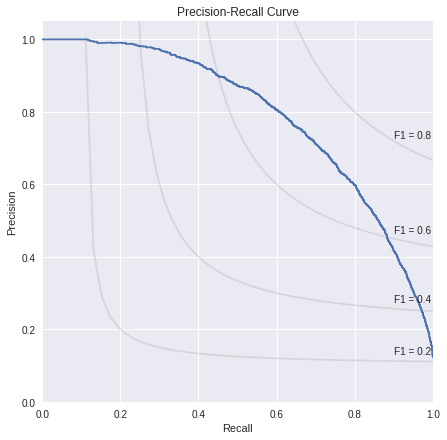

In [0]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

inputs = torch.LongTensor(X_test)
model = model.cpu()
logits = model(inputs)
logits = logits.data.cpu().numpy()
precision, recall, _ = precision_recall_curve(test_labels, logits)

plt.figure(figsize=(7, 7))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('F1 = {0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

plt.plot(recall, precision)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.show()

<!-- ![ConvNN](https://image.ibb.co/mEsdWL/Conv.png) ![DropoutConvNN](https://image.ibb.co/mb8Dy0/Dropout-BNConv.png) ![MultConvNN](https://image.ibb.co/bYYDy0/Multiple-convs.png) -->
![alt text](https://preview.ibb.co/gNL7rL/nns-to-compare.jpg)

Слева направо: изначальная сеточка, сеточка с дропаутами и батчнормом, сеточка с 3 свертками, и все прочим ¯\_(ツ)_/¯

# Сдача задания

[Форма](https://goo.gl/forms/FfMnyNGI2P4xo0QD3)